**Author:** [Riccardo Guidotti](http://kdd.isti.cnr.it/people/riccardo-guidotti)  
**Python version:**  3.x

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from collections import defaultdict

# Data Preparation

In [ ]:
class_name = 'Occupancy'
df = pd.read_csv('occupancy_data/datatraining.txt', skipinitialspace=True, na_values='?', keep_default_na=True)
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [ ]:
def daytime(h):
    if 6 <= h < 13:
        return 'morning'
    elif 13 <= h < 18:
        return 'afternoon'
    elif 18 <= h < 22:
        return 'evening'
    return 'night'

In [ ]:
df['daytime'] = [daytime(d.hour) for d in pd.to_datetime(df['date'])]
df['weekend'] = [1 if d.weekday() >= 5 else 0 for d in pd.to_datetime(df['date'])]
columns2remove = ['date']
df.drop(columns2remove, inplace=True, axis=1)
df0 = df.copy()
dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
dfY = df[class_name]
df = pd.concat([dfX, dfY], axis=1)
df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,weekend,daytime=afternoon,daytime=evening,daytime=morning,daytime=night,Occupancy
1,23.18,27.2720,426.0,721.25,0.004793,0,1,0,0,0,1
2,23.15,27.2675,429.5,714.00,0.004783,0,1,0,0,0,1
3,23.15,27.2450,426.0,713.50,0.004779,0,1,0,0,0,1
4,23.15,27.2000,426.0,708.25,0.004772,0,1,0,0,0,1
5,23.10,27.2000,426.0,704.50,0.004757,0,1,0,0,0,1


In [ ]:
df[class_name].value_counts()

0    6414
1    1729
Name: Occupancy, dtype: int64

In [ ]:
rows2remove = np.random.choice(df[df[class_name] == 1].index, 1729 - 129, replace=False)

In [ ]:
len(df), len(rows2remove)

(8143, 1600)

In [ ]:
df2 = df.drop(index=rows2remove, axis=0)
print(len(df2))

6543


In [ ]:
print('Dataset shape %s' % Counter(df2[class_name]))

Dataset shape Counter({0: 6414, 1: 129})


In [ ]:
129/(6414 + 129)*100

1.9715726730857406

# Data Partitioning

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [ ]:
attributes = [col for col in df.columns if col != class_name]
X = df2[attributes].values
y = df2[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [ ]:
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1]), array([4490,   90])), (array([0, 1]), array([1924,   39])))

# Classification

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train, y_train)

y_pred0 = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0))
print('F1-score %s' % f1_score(y_test, y_pred0, average=None))
print(classification_report(y_test, y_pred0))

Accuracy 0.9959246051961284
F1-score [0.99792423 0.88888889]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1924
           1       0.97      0.82      0.89        39

    accuracy                           1.00      1963
   macro avg       0.98      0.91      0.94      1963
weighted avg       1.00      1.00      1.00      1963



# ROC curve

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [ ]:
y_score = clf.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

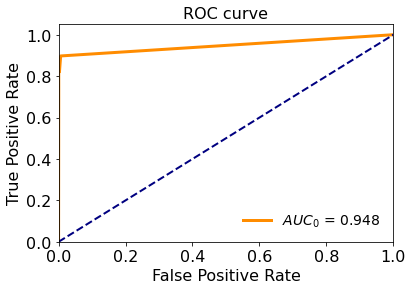

In [ ]:
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# Adjust the Decision Threshold

Accuracy 0.9943963321446765
F1-score [0.99714804 0.84057971]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1924
           1       0.97      0.74      0.84        39

    accuracy                           0.99      1963
   macro avg       0.98      0.87      0.92      1963
weighted avg       0.99      0.99      0.99      1963



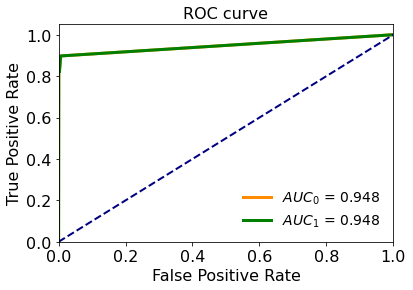

In [ ]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train, y_train)

def adjusted_predict(X, thr=0.5):
    y_score = clf.predict_proba(X_test)[:, 1]
    return np.array([1 if y > thr else 0 for y in y_score])

y_pred = adjusted_predict(X_test, thr=0.8)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, thr = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [ ]:
clf.predict(X_test[:5])

array([0, 0, 0, 0, 0])

In [ ]:
clf.predict_proba(X_test[:5])

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [ ]:
if clf.predict_proba(X_test[116].reshape(1,-1))[:,1] > 0.2:
    print(1)
else:
    print(0)

1


In [ ]:
clf.predict(X_test[116].reshape(1,-1))

array([0])

In [ ]:
np.where(clf.predict_proba(X_test)[:,1] > 0)

(array([  65,  107,  116,  147,  148,  149,  151,  197,  234,  243,  340,
         347,  399,  413,  417,  482,  527,  551,  598,  602,  633,  698,
         780,  826,  869,  913,  922, 1080, 1132, 1141, 1154, 1165, 1217,
        1244, 1249, 1316, 1333, 1408, 1455, 1537, 1595, 1680, 1717, 1754,
        1858, 1871, 1881]),)

In [ ]:
clf.predict_proba(X_test)[:,1][np.where(clf.predict_proba(X_test)[:,1] > 0)]

array([1.        , 1.        , 0.33333333, 1.        , 1.        ,
       0.33333333, 0.33333333, 0.66666667, 0.33333333, 1.        ,
       1.        , 0.5       , 1.        , 1.        , 1.        ,
       1.        , 0.33333333, 0.33333333, 0.33333333, 1.        ,
       0.5       , 0.33333333, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.33333333, 0.33333333,
       1.        , 1.        , 0.5       , 0.5       , 1.        ,
       1.        , 0.75      , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.66666667, 1.        ,
       1.        , 1.        ])

In [ ]:
clf.predict_proba(X_test)[:,0][np.where(clf.predict_proba(X_test)[:,1] > 0)]

array([0.        , 0.        , 0.66666667, 0.        , 0.        ,
       0.66666667, 0.66666667, 0.33333333, 0.66666667, 0.        ,
       0.        , 0.5       , 0.        , 0.        , 0.        ,
       0.        , 0.66666667, 0.66666667, 0.66666667, 0.        ,
       0.5       , 0.66666667, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.66666667, 0.66666667,
       0.        , 0.        , 0.5       , 0.5       , 0.        ,
       0.        , 0.25      , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.33333333, 0.        ,
       0.        , 0.        ])

# PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
X_train.shape

(4580, 10)

In [ ]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_train)

In [ ]:
X_pca.shape

(4580, 2)

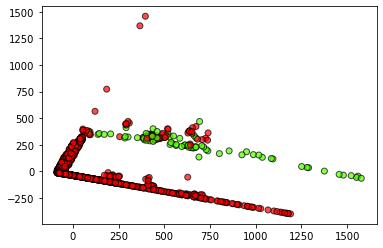

In [ ]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

# Undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour

### RandomUnderSampler

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 90, 1: 90})


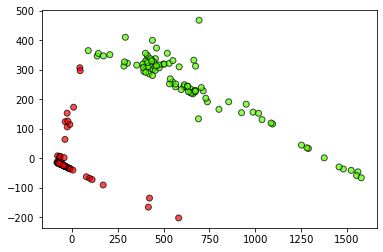

In [ ]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.9852266938359654
F1-score [0.99241036 0.72380952]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1924
           1       0.58      0.97      0.72        39

    accuracy                           0.99      1963
   macro avg       0.79      0.98      0.86      1963
weighted avg       0.99      0.99      0.99      1963



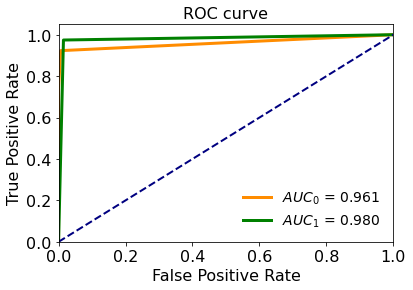

In [ ]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

### CondensedNearestNeighbour

In [ ]:
import warnings
warnings.simplefilter("ignore")

In [ ]:
cnn = CondensedNearestNeighbour(random_state=42, n_jobs=10)
X_res, y_res = cnn.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 90, 0: 38})


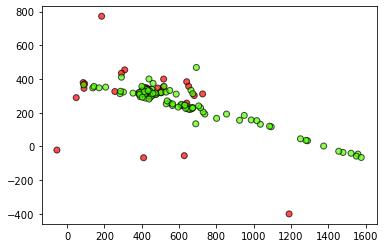

In [ ]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.9490575649516046
F1-score [0.9733901 0.4047619]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1924
           1       0.26      0.87      0.40        39

    accuracy                           0.95      1963
   macro avg       0.63      0.91      0.69      1963
weighted avg       0.98      0.95      0.96      1963



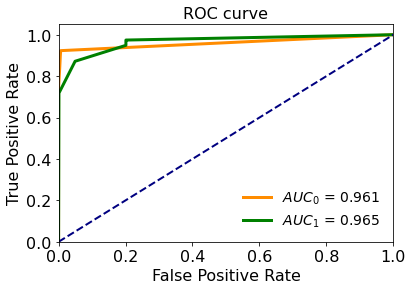

In [ ]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# Oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

### RandomOverSampler

In [ ]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 4490, 1: 4490})


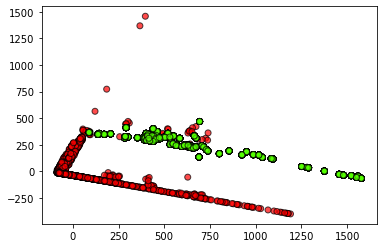

In [ ]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.9943963321446765
F1-score [0.99714063 0.86075949]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1924
           1       0.85      0.87      0.86        39

    accuracy                           0.99      1963
   macro avg       0.92      0.93      0.93      1963
weighted avg       0.99      0.99      0.99      1963



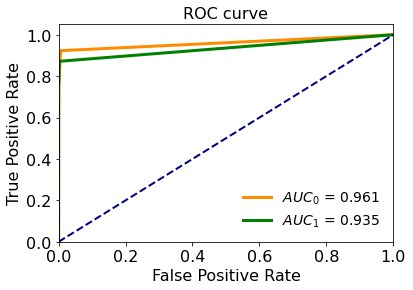

In [ ]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

### SMOTE

In [ ]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 4490, 1: 4490})


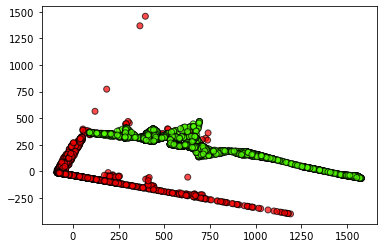

In [ ]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.9949057564951604
F1-score [0.9973999 0.875    ]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1924
           1       0.85      0.90      0.88        39

    accuracy                           0.99      1963
   macro avg       0.93      0.95      0.94      1963
weighted avg       1.00      0.99      0.99      1963



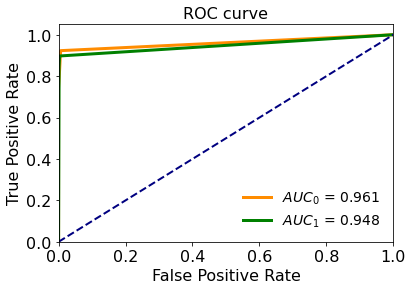

In [ ]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# Class Weight 

Accuracy 0.9954151808456444
F1-score [0.9976593  0.88888889]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1924
           1       0.86      0.92      0.89        39

    accuracy                           1.00      1963
   macro avg       0.93      0.96      0.94      1963
weighted avg       1.00      1.00      1.00      1963



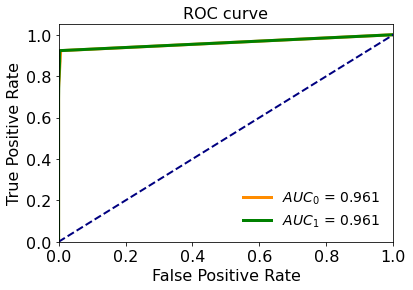

In [ ]:
clf = DecisionTreeClassifier(min_samples_leaf=3, class_weight={0:1, 1: 5}, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# Meta-Cost Sensitive Classifier

In [ ]:
from costcla.models import CostSensitiveDecisionTreeClassifier
from costcla.metrics import savings_score

ModuleNotFoundError: No module named 'sklearn.externals.joblib'

cost_mat : array-like of shape = [n_samples, 4]

Cost matrix of the classification problem Where the columns represents the costs of: false positives, false negatives, true positives and true negatives, for each example.

In [ ]:
cost = [1, 10, 0, 0]
cost_mat = np.array([cost] * len(X_train))
cost_mat.shape

(2333, 4)

In [ ]:
cost_mat

array([[ 1, 10,  0,  0],
       [ 1, 10,  0,  0],
       [ 1, 10,  0,  0],
       ...,
       [ 1, 10,  0,  0],
       [ 1, 10,  0,  0],
       [ 1, 10,  0,  0]])

Accuracy 0.426
F1-score [0.51273345 0.30170316]
              precision    recall  f1-score   support

           0       0.93      0.35      0.51       855
           1       0.18      0.86      0.30       145

    accuracy                           0.43      1000
   macro avg       0.56      0.60      0.41      1000
weighted avg       0.83      0.43      0.48      1000



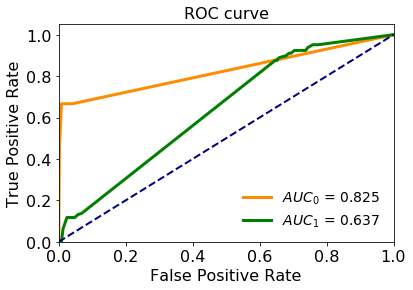

In [ ]:
clf = CostSensitiveDecisionTreeClassifier()
clf.fit(X_train, y_train, cost_mat)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [ ]:
cost_mat_test = np.array([cost] * len(X_test))
print(savings_score(y_test, y_pred, cost_mat_test))
print(savings_score(y_test, y_pred0, cost_mat_test))

0.10760233918128659


ValueError: operands could not be broadcast together with shapes (870,) (1000,) 

# Scikit-plot

In [ ]:
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve

In [ ]:
#attributes = [col for col in df.columns if col != class_name]
attributes = ['Humidity']
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

clf = DecisionTreeClassifier(max_depth=1, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7998362668849774
F1-score [0.88293033 0.31029619]
              precision    recall  f1-score   support

           0       0.82      0.96      0.88      1924
           1       0.58      0.21      0.31       519

    accuracy                           0.80      2443
   macro avg       0.70      0.59      0.60      2443
weighted avg       0.77      0.80      0.76      2443



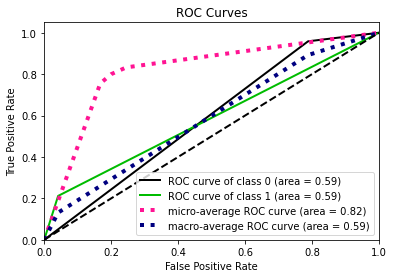

In [ ]:
plot_roc(y_test, y_score)
plt.show()

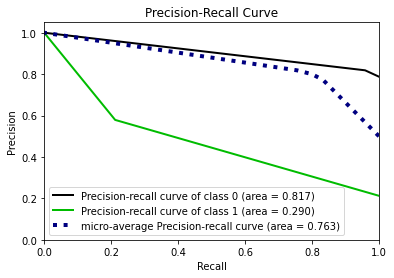

In [ ]:
plot_precision_recall(y_test, y_score)
plt.show()

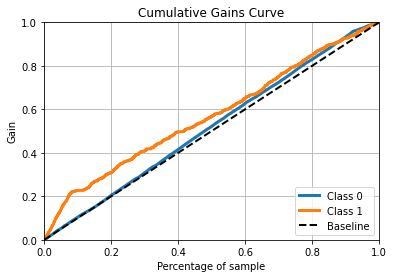

In [ ]:
plot_cumulative_gain(y_test, y_score)
plt.show()

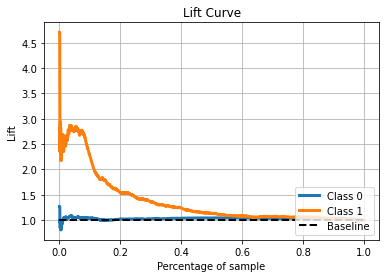

In [ ]:
plot_lift_curve(y_test, y_score)
plt.show()